<a href="https://colab.research.google.com/github/Panagiotis-Bosinas/Machine_Learning_Assignments/blob/main/Ergasia7_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB

## Ερώτημα 1

In [ ]:
df= pd.read_csv('train.csv')
df

In [ ]:
seed = 0
test_size = 0.1

train_set, test_set = train_test_split(df, test_size=test_size, random_state=seed, stratify=df['target'])
train_set.shape, test_set.shape

In [ ]:
train_counts = train_set["target"].value_counts()
test_counts = test_set["target"].value_counts()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(train_counts.index.astype(str), train_counts.values)
plt.title("Train Target")
plt.xlabel("Target")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.bar(test_counts.index.astype(str), test_counts.values)
plt.title("Test Target")
plt.xlabel("Target")
plt.ylabel("Count")

plt.show()

Το dataset, όπως φαίνεται από τα ραβδογράμματα, δεν είναι ισορροπημένο. Ωστόσο, η ανισσοροπία αυτή δεν είναι υπερβολικά μεγάλη.

## Ερώτημα 2

In [ ]:
train_set = train_set.drop(columns=['id', 'location'])
test_set  = test_set.drop(columns=['id', 'location'])

train_set = train_set.fillna('null')
test_set  = test_set.fillna('null')

train_set['inputs'] = train_set['keyword'] + ' ' + train_set['text']
test_set['inputs']  = test_set['keyword'] + ' ' + test_set['text']

## Ερώτημα 3

In [ ]:
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def countMultiExclamationMarks(text):
    """ Replaces repetitions of exlamation marks """
    return len(re.findall(r"(\!)\1+", text))

def countMultiQuestionMarks(text):
    """ Count repetitions of question marks """
    return len(re.findall(r"(\?)\1+", text))

def countMultiStopMarks(text):
    """ Count repetitions of stop marks """
    return len(re.findall(r"(\.)\1+", text))

def countElongated(text):
    """ Input: a text, Output: how many words are elongated """
    regex = re.compile(r"(.)\1{2}")
    return len([word for word in text.split() if regex.search(word)])

def countAllCaps(text):
    """ Input: a text, Output: how many words are all caps """
    return len(re.findall("[A-Z0-9]{3,}", text))

""" Creates a dictionary with slangs and their equivalents and replaces them """
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def countSlang(text):
    """ Input: a text, Output: how many slang words and a list of found slangs """
    slangCounter = 0
    slangsFound = []
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        if word in slang_words:
            slangsFound.append(word)
            slangCounter += 1
    return slangCounter, slangsFound

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:
        return replaceElongated(repl_word)
    else:
        return repl_word

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


### Spell Correction begin ###
""" Spell Correction http://norvig.com/spell-correct.html """
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('corporaForSpellCorrection.txt').read()))

def P(word, N=sum(WORDS.values())):
    """P robability of `word`. """
    return WORDS[word] / N

def spellCorrection(word):
    """ Most probable spelling correction for word. """
    return max(candidates(word), key=P)

def candidates(word):
    """ Generate possible spelling corrections for word. """
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    """ The subset of `words` that appear in the dictionary of WORDS. """
    return set(w for w in words if w in WORDS)

def edits1(word):
    """ All edits that are one edit away from `word`. """
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    """ All edits that are two edits away from `word`. """
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

### Spell Correction End ###

### Replace Negations Begin ###

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
      word = text[i]
      if word == 'not' and i+1 < l:
        ant = replace(text[i+1])
        if ant:
          words.append(ant)
          i += 2
          continue
      words.append(word)
      i += 1
    return words

def addCapTag(word):
    """ Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_ """
    if(len(re.findall("[A-Z]{3,}", word))):
        word = word.replace('\\', '' )
        transformed = re.sub("[A-Z]{3,}", "ALL_CAPS_"+word, word)
        return transformed
    else:
        return word

In [ ]:
def clean_tweet(text):
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeNumbers(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = removeEmoticons(text)
    text = replaceSlang(text)
    text = replaceContraction(text)
    text = addCapTag(text)
    text = replaceElongated(text)
    return text

train_set["clean_inputs"] = train_set["inputs"].astype(str).apply(clean_tweet)
test_set["clean_inputs"]  = test_set["inputs"].astype(str).apply(clean_tweet)

Οι τεχνικές που επιλέχθηκαν είναι η removeUnicode η οποία αφαιρεί από τα tweet περίεργους Unicode χαρακτήρες, οι replaceURL και replaceAtUser που αντικαθιστούν τα URLs και τα "@" με την λέξη "url" και "atUser" αντίστοιχα, η removeHashtagInFrontOfWord που αφαιρεί τους χαρακτήρες "#", η removeNumbers που αφαιρεί τους αριθμούς, οι replaceMultiExclamationMark,replaceMultiQuestionMark και replaceMultiStopMark που αντικαθιστούν τις σειρές με πολλαπλά σημεία στήξης που μπορεί να δηλώνουν έμφαση και κάποια επίγουσα κατάσταση με τα αντίστοιχα strings και η removeEmoticons που αφαιρεί τα emoticons. Επίσης, χρησιμοποιήθηκε η replaceSlang που αντικαθιστά τα slang του καταλόγου "slang.txt" με τις ολοκληρομένες δόκιμες λέξεις, η replaceContraction που αντικαθιστά τις συντομογραφίες, η replaceElongated που αντικαθιστά μακρόσυρτες λέξεις όπως "soooo", και την addCapTag που κάνει flag μια λέξη όταν είναι στα κεφαλαία, το οποίο είναι σημαντικό γιατί μπορεί να δηλώνει έντονα συναισθήματα και επιτακτική ανάγκη.

Δεν επιλέχθηκαν κάποιες άλλες τεχνικές όπως Stemming και Lemmatizing οι οποίες αφαιρούν καταλήξεις και προθέματα και κρατούν μόνο την βασική μορφή των λέξεων, το οποίο δεν κρίνεται αναγκαίο και μπορεί να αφαιρέσει σημαντική πληροφορία. Για τον ίδιο λόγο δεν αφαιρέθηκαν τα stopwords. Για παράδειγμα, έχει σημασία αν ένα tweet έχει την φράση "had burned" αντί για "is burning" που εκφράζει μία καταστροφή σε εξέλιξη. Με τις παραπάνω τεχνικές, το μοντέλο θα τα αντιμετώπιζε ως ίδιες περιπτώσεις.




## Ερώτημα 4

In [ ]:
x_train = train_set['clean_inputs'].to_numpy()
y_train = train_set['target'].to_numpy()

x_test = test_set['clean_inputs'].to_numpy()
y_test = test_set['target'].to_numpy()

## Ερώτημα 5

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(train_set['clean_inputs'])
X_test_tfidf  = tfidf.transform(test_set['clean_inputs'])
X_train_tfidf.shape, X_test_tfidf.shape

## Ερώτημα 6

In [ ]:
svm_lin = LinearSVC(random_state=seed)

svm_lin.fit(X_train_tfidf, y_train)

y_train_pred = svm_lin.predict(X_train_tfidf)
y_test_pred  = svm_lin.predict(X_test_tfidf)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
print(f"Test set:")
print(f'Accuracy: {test_acc*100:.2f}')
print(f'Precision: {test_prec*100:.2f}')
print(f'Recall: {test_rec*100:.2f}')
print(f'F1: {test_f1*100:.2f}')

print("\nTrain set:")
print(f'Accuracy: {train_acc*100:.2f}')
print(f'Precision: {train_prec*100:.2f}')
print(f'Recall: {train_rec*100:.2f}')
print(f'F1: {train_f1*100:.2f}')

Η πιο σημαντική μετρική από άποψη αξιοπιστίας είναι το f1, αφού το dataset δεν είναι balanced και άρα την προτιμούμε από την accuracy. Η recall είναι επίσης σημαντική, αφού δεν θα θέλαμε να μην αναγνωρίσει το μοντέλο κάποια φυσική καταστροφή ενώ αυτή εκτυλίσσεται.

## Ερώτημα 7

In [11]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca  = pca.transform(X_test_tfidf.toarray())


In [12]:
X_train_pca.shape

(6851, 3716)

In [14]:
linear_svm = LinearSVC(random_state=seed)
linear_svm.fit(X_train_pca, y_train)
y_test_pred_linear = linear_svm.predict(X_test_pca)
y_train_pred_linear = linear_svm.predict(X_train_pca)

rbf_svm = SVC(kernel='rbf', random_state=seed)
rbf_svm.fit(X_train_pca, y_train)
y_test_pred_rbf = rbf_svm.predict(X_test_pca)
y_train_pred_rbf = rbf_svm.predict(X_train_pca)

test_acc_linear = accuracy_score(y_test, y_test_pred_linear)
test_prec_linear = precision_score(y_test, y_test_pred_linear)
test_rec_linear = recall_score(y_test, y_test_pred_linear)
test_f1_linear = f1_score(y_test, y_test_pred_linear)

train_acc_linear = accuracy_score(y_train, y_train_pred_linear)
train_prec_linear = precision_score(y_train, y_train_pred_linear)
train_rec_linear = recall_score(y_train, y_train_pred_linear)
train_f1_linear = f1_score(y_train, y_train_pred_linear)
print(f"Test set Linear:")
print(f'Accuracy: {test_acc_linear*100:.2f}')
print(f'Precision: {test_prec_linear*100:.2f}')
print(f'Recall: {test_rec_linear*100:.2f}')
print(f'F1: {test_f1_linear*100:.2f}')

print("\nTrain set Linear:")
print(f'Accuracy: {train_acc_linear*100:.2f}')
print(f'Precision: {train_prec_linear*100:.2f}')
print(f'Recall: {train_rec_linear*100:.2f}')
print(f'F1: {train_f1_linear*100:.2f}')

test_acc_rbf = accuracy_score(y_test, y_test_pred_rbf)
test_prec_rbf = precision_score(y_test, y_test_pred_rbf)
test_rec_rbf = recall_score(y_test, y_test_pred_rbf)
test_f1_rbf = f1_score(y_test, y_test_pred_rbf)

train_acc_rbf = accuracy_score(y_train, y_train_pred_rbf)
train_prec_rbf = precision_score(y_train, y_train_pred_rbf)
train_rec_rbf = recall_score(y_train, y_train_pred_rbf)
train_f1_rbf = f1_score(y_train, y_train_pred_rbf)
print(f"\nTest set RBF:")
print(f'Accuracy: {test_acc_rbf*100:.2f}')
print(f'Precision: {test_prec_rbf*100:.2f}')
print(f'Recall: {test_rec_rbf*100:.2f}')
print(f'F1: {test_f1_rbf*100:.2f}')

print("\nTrain set RBF:")
print(f'Accuracy: {train_acc_rbf*100:.2f}')
print(f'Precision: {train_prec_rbf*100:.2f}')
print(f'Recall: {train_rec_rbf*100:.2f}')
print(f'F1: {train_f1_rbf*100:.2f}')

Test set Linear:
Accuracy: 81.23
Precision: 79.11
Recall: 76.45
F1: 77.76

Train set Linear:
Accuracy: 93.75
Precision: 95.51
Recall: 89.67
F1: 92.50

Test set RBF:
Accuracy: 81.63
Precision: 80.46
Recall: 75.54
F1: 77.92

Train set RBF:
Accuracy: 94.45
Precision: 97.34
Recall: 89.54
F1: 93.28


To linear και το RBF kernel φαίνεται να έχουν σχεδόν τις ίδιες επιδόσεις. Το μοντέλο με το RBF φαίνεται να έχει λίγο υψηλότερο accuracy, precision και F1, ενώ το μοντέλο με το γραμμικό kernel έχει λίγο υψηλότερο recall.

## Ερώτημα 8

Η τιμή gamma που χρηισμοποιείται για gamma='scale' είναι το αντίστροφο του γινομένου του αριθμού των features με την διασπορά των δεδομένων. Η τιμή 'auto' είναι μόνο το αντίστροφο του αριθμού των features.  

In [15]:
auto_svm = SVC(kernel='rbf', gamma='auto', random_state=seed)
auto_svm.fit(X_train_pca, y_train)

y_test_pred_auto = auto_svm.predict(X_test_pca)
y_train_pred_auto = auto_svm.predict(X_train_pca)

In [16]:
test_acc_auto = accuracy_score(y_test, y_test_pred_auto)
test_prec_auto = precision_score(y_test, y_test_pred_auto)
test_rec_auto = recall_score(y_test, y_test_pred_auto)
test_f1_auto = f1_score(y_test, y_test_pred_auto)

train_acc_auto = accuracy_score(y_train, y_train_pred_auto)
train_prec_auto = precision_score(y_train, y_train_pred_auto)
train_rec_auto = recall_score(y_train, y_train_pred_auto)
train_f1_auto = f1_score(y_train, y_train_pred_auto)
print(f"\nTest set RBF:")
print(f'Accuracy: {test_acc_auto*100:.2f}')
print(f'Precision: {test_prec_auto*100:.2f}')
print(f'Recall: {test_rec_auto*100:.2f}')
print(f'F1: {test_f1_auto*100:.2f}')

print("\nTrain set RBF:")
print(f'Accuracy: {train_acc_auto*100:.2f}')
print(f'Precision: {train_prec_auto*100:.2f}')
print(f'Recall: {train_rec_auto*100:.2f}')
print(f'F1: {train_f1_auto*100:.2f}')


Test set RBF:
Accuracy: 57.09
Precision: 0.00
Recall: 0.00
F1: 0.00

Train set RBF:
Accuracy: 57.03
Precision: 0.00
Recall: 0.00
F1: 0.00


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ορίζουμε συνάρτηση για τις μετρικές για να μην τις ξαναγράφουμε από την αρχή.

In [17]:
def metrics(y_real,y_pred):
    return {
        "Accuracy": accuracy_score(y_real, y_pred) * 100,
        "Precision": precision_score(y_real, y_pred) * 100,
        "Recall": recall_score(y_real, y_pred) * 100,
        "F1": f1_score(y_real, y_pred) * 100}

Dictionary με τις μετρικές

In [18]:
results = {"LinearSVC": metrics(y_test, y_test_pred),
    "LinearSVC with PCA": metrics(y_test, y_test_pred_linear),
    "RBF SVC (scale) with PCA": metrics(y_test, y_test_pred_rbf),
    "RBF SVC (auto) with PCA": metrics(y_test, y_test_pred_auto)}

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Κατασκευάζουμε το plot των μετρικών για το κάθε μοντέλο

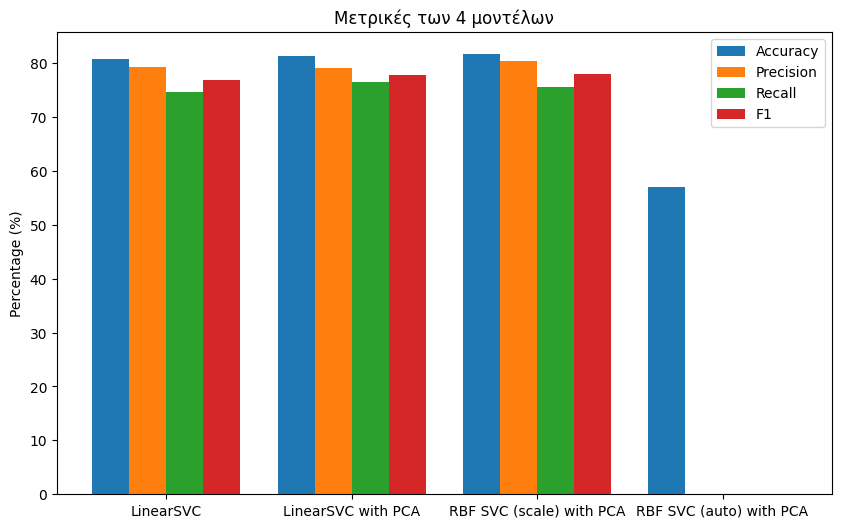

In [19]:

metrics = ["Accuracy", "Precision", "Recall", "F1"]
models = list(results.keys())
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))


plt.bar(x, [results[m]["Accuracy"] for m in models], width=width, label="Accuracy")
plt.bar(x + width, [results[m]["Precision"] for m in models], width=width, label="Precision")
plt.bar(x + 2*width, [results[m]["Recall"] for m in models], width=width, label="Recall")
plt.bar(x + 3*width, [results[m]["F1"] for m in models], width=width, label="F1")

plt.xticks(x + 1.5*width, models)
plt.ylabel("Percentage (%)")
plt.title("Μετρικές των 4 μοντέλων")
plt.legend()
plt.show()

Από το διάγραμμα βλέπουμε ότι το PCA είχε μια μικρή θετική επίδραση στην επίδοση του μοντέλου. Ακόμη, όπως αναφέρθηκε παραπάνω, το γραμμικό και το RBF μοντέλο δεν έχουν αισθητή διαφορά μεταξύ τους, με το RBF να είναι γενικά ελφρώς καλύτερο ενώ το γραμμικό μοντέλο δίνει ελάχιστα καλύτερο recall. Το RBF SVC με auto στο gamma έχει πολύ κακή επίδοση. Από τα αποτελέσματα φαίνεται να μην μαθαίνει τίποτα και απλά ταξινομεί όλα τα δείγματα στην κλάση 0. Για αυτό έχει 57% accuracy αλλά 0% στις υπόλοιπες μετρικές.

## Ερώτημα 9

In [21]:
bayes = GaussianNB()

bayes.fit(X_train_tfidf.toarray(), y_train)

y_train_pred_bayes = bayes.predict(X_train_tfidf.toarray())
y_test_pred_bayes  = bayes.predict(X_test_tfidf.toarray())

test_acc_bayes = accuracy_score(y_test, y_test_pred_bayes)
test_prec_bayes = precision_score(y_test, y_test_pred_bayes)
test_rec_bayes = recall_score(y_test, y_test_pred_bayes)
test_f1_bayes = f1_score(y_test, y_test_pred_bayes)

train_acc_bayes = accuracy_score(y_train, y_train_pred_bayes)
train_prec_bayes = precision_score(y_train, y_train_pred_bayes)
train_rec_bayes = recall_score(y_train, y_train_pred_bayes)
train_f1_bayes = f1_score(y_train, y_train_pred_bayes)
print(f"\nTest set RBF:")
print(f'Accuracy: {test_acc_bayes*100:.2f}')
print(f'Precision: {test_prec_bayes*100:.2f}')
print(f'Recall: {test_rec_bayes*100:.2f}')
print(f'F1: {test_f1_bayes*100:.2f}')

print("\nTrain set RBF:")
print(f'Accuracy: {train_acc_bayes*100:.2f}')
print(f'Precision: {train_prec_bayes*100:.2f}')
print(f'Recall: {train_rec_bayes*100:.2f}')
print(f'F1: {train_f1_bayes*100:.2f}')


Test set RBF:
Accuracy: 62.07
Precision: 53.94
Recall: 79.51
F1: 64.28

Train set RBF:
Accuracy: 87.74
Precision: 77.80
Recall: 100.00
F1: 87.51


Ο naive Bayes φαίνεται να έχει χαμηλότερη επίδοση. Αυτό ίσως γίνεται γιατί υποθέτει ότι τα χαρακτηριστικά, δηλαδή οι λέξεις, είναι ανεξάρτητα μεταξύ τους, το οποίο μπορεί να μην είναι αληθές. Επιπλέον, γενικά τα SVM είναι καλύτερα από τους περισσότερους άλλους αλγόριθμους στο να χειρίζονται προβλήματα με πολλά features.